In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

In [2]:
installs_dtypes = {'application_id': 'category', 'kind': 'category'}

installs = pd.read_csv('installs.csv', dtype = installs_dtypes)
installs["created"] =  pd.to_datetime(installs["created"], errors = "coerce") #parseo de fechas
installs.drop('attributed', axis = 1, inplace = True) #son todas false
installs.drop('click_hash', axis = 1, inplace = True) #son todas NaN

In [3]:
clicks_dtypes = {'advertiser': np.int8, 'action_id': np.float16, 'source_id': np.int8, 'country_code': 'category',
                 'latitude': np.float16, 'longitude': np.float16, 'carrier_id': np.float16, 'brand': np.float16,
                 'touchX': np.float16, 'touchY': np.float16}

clicks = pd.read_csv('clicks.csv', dtype = clicks_dtypes)
clicks["created"] =  pd.to_datetime(clicks["created"], errors = "coerce") #parseo de fechas
clicks.drop('action_id', axis = 1, inplace = True) #todos NaN
clicks.drop('wifi_connection', axis = 1, inplace = True) #todos False

In [4]:
events = pd.read_csv('events.csv', low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

In [5]:
auctions = pd.read_csv('auctions.csv')
auctions["date"] =  pd.to_datetime(auctions["date"], errors = "coerce")
auctions.drop('auction_type_id', axis = 1, inplace = True)  #todas Nan

# Analisis de user agent

In [13]:
installs.columns

Index(['created', 'application_id', 'ref_type', 'ref_hash', 'implicit',
       'device_countrycode', 'device_brand', 'device_model',
       'session_user_agent', 'user_agent', 'event_uuid', 'kind', 'wifi',
       'trans_id', 'ip_address', 'device_language', 'os'],
      dtype='object')

In [14]:
events.columns

Index(['date', 'event_id', 'ref_type', 'ref_hash', 'application_id',
       'attributed', 'device_countrycode', 'device_os_version', 'device_brand',
       'device_model', 'device_city', 'session_user_agent', 'trans_id',
       'user_agent', 'event_uuid', 'carrier', 'kind', 'device_os', 'wifi',
       'connection_type', 'ip_address', 'device_language'],
      dtype='object')

In [15]:
auctions.columns

Index(['country', 'date', 'device_id', 'platform', 'ref_type_id', 'source_id'], dtype='object')

In [16]:
clicks.columns

Index(['advertiser_id', 'source_id', 'created', 'country_code', 'latitude',
       'longitude', 'carrier_id', 'trans_id', 'os_minor', 'agent_device',
       'os_major', 'specs_brand', 'brand', 'timeToClick', 'touchX', 'touchY',
       'ref_type', 'ref_hash'],
      dtype='object')

In [17]:
installs.implicit.value_counts()

False    2547
True      865
Name: implicit, dtype: int64

In [20]:
def obtener_grafo(df):
    df_from = []
    df_to = []
    last_event = None
    last_ref = None
    for a,row in df.iterrows():
        event = row["event_id"]
        ref = row["ref_hash"]
        
        if ref != last_ref:
            event == None
        elif(event and event != last_event):
            df_from.append(last_event)
            df_to.append(event)
        
        last_ref = ref
        last_event = event
    return pd.DataFrame({"from":df_from,"to":df_to}).drop_duplicates()
        

In [21]:
grafo_eventos = events.loc[events['ref_hash'].isin(installs["ref_hash"].unique()),["date","event_id","ref_hash"]]
grafo_eventos.sort_values("date",inplace=True)
grafo_eventos.sort_values("ref_hash",inplace=True)
grafo_eventos_aristas = obtener_grafo(grafo_eventos)
grafo_eventos_aristas.head(3)

,from,to
0,82,1
1,1,82
2,82,81


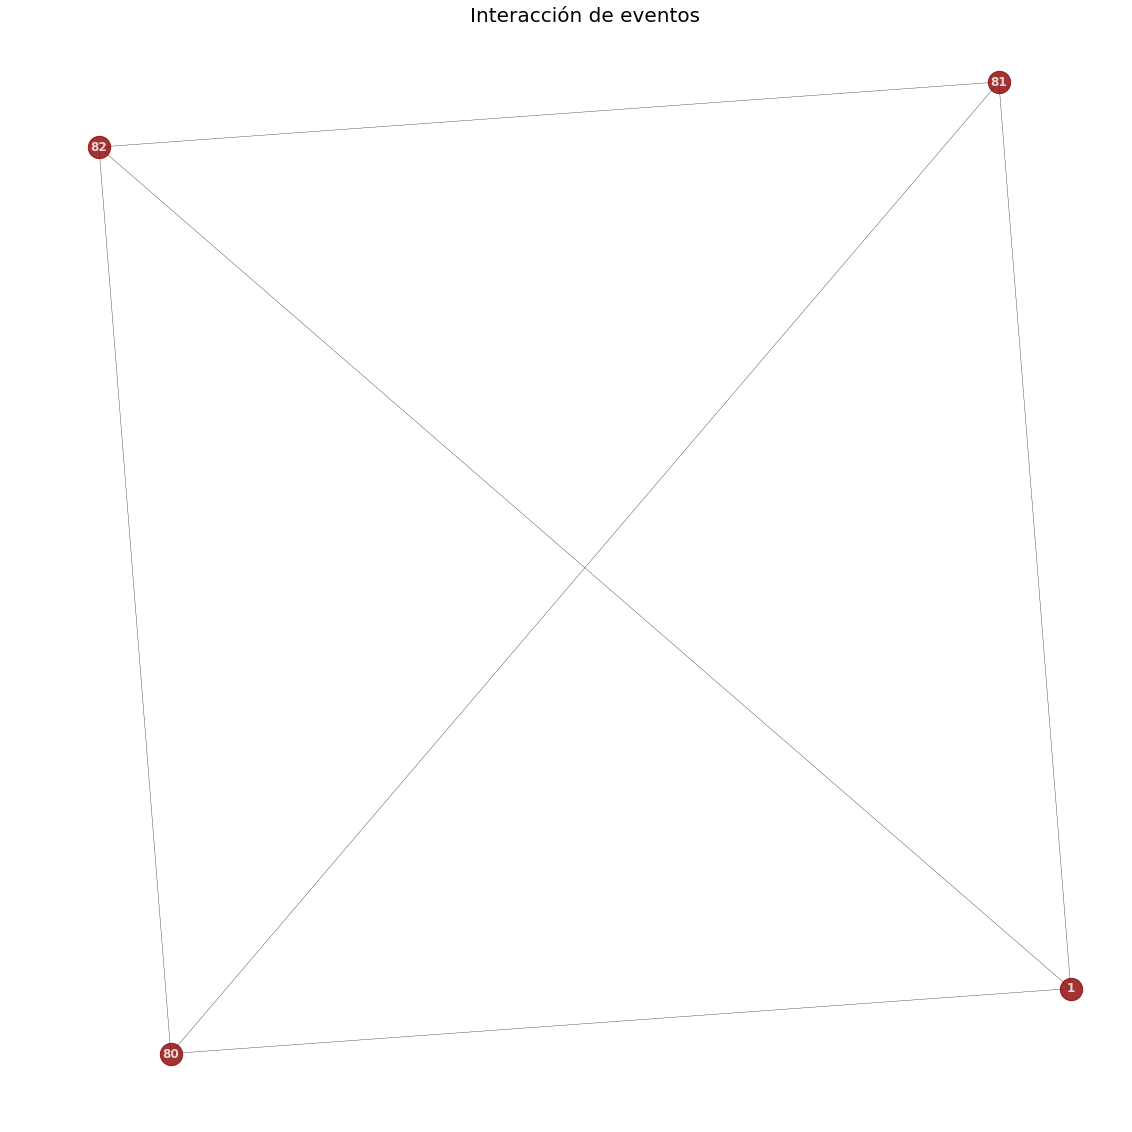

In [25]:
import networkx as nx
 
G=nx.from_pandas_edgelist(grafo_eventos_aristas, 'from', 'to')
plt.figure(figsize=(15,15)) 
nx.draw(G, alpha=0.8, node_size=500, width=0.4, node_color="darkred",font_color="white", font_weight="bold",with_labels=True)
plt.title("Interacción de eventos",size=20)
plt.show()

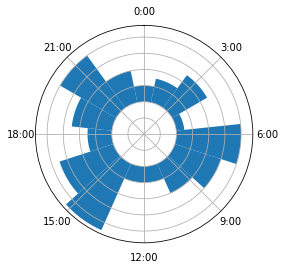

In [23]:
N = 24
bottom = 4
max_height = 10

radii = [2,3,5,1,8,6,4,2,2,9,7,3,5,8,4] 
theta = np.linspace(0.0, 2 * np.pi, len(radii), endpoint=False)
width = (2*np.pi) / len(radii)

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)
ax.set_yticklabels([])
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.set_xticklabels(['0:00', '3:00', '6:00', '9:00', '12:00', '15:00', '18:00', '21:00'])

plt.show()

In [74]:
fig = {
  "data": [
    {
      "values": installs["implicit"].value_counts(),
      "labels": [
        "No implicito",
          "Implicito"
      ],
      "hole": .5,
      "type": "pie"
    }],
  "layout": {
        "title":"Porcentaje de installs implícito",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Installs"
            }
        ]
    }
}
py.offline.iplot(fig)

In [126]:
cant_horas_anteriores = 48
installs_to_join = installs.loc[ installs["created"] > pd.to_datetime("2019-03-06") , ["ref_hash","application_id","created"]]
installs_to_join = installs_to_join.groupby(["ref_hash","application_id"]).agg({"created":"min"}).reset_index()
installs_to_join["index"] = installs_to_join.index
installs_to_join.head()

,ref_hash,application_id,created,index
0,4958526679100225,10,2019-03-09 15:24:03.123,0
1,5610335643679608,7,2019-03-08 23:56:00.134,1
2,12589600065022004,8,2019-03-11 03:01:40.186,2
3,13755514797422075,7,2019-03-11 22:13:03.705,3
4,14817751128061288,7,2019-03-13 02:43:14.119,4


In [127]:
auc_and_installs = auctions.loc[:,["date","device_id"]].merge(installs_to_join,left_on="device_id",right_on="ref_hash",how="inner")
auc_and_installs["diff"] = (auc_and_installs["created"] - auc_and_installs["date"]) / np.timedelta64(1, 'h')
auc_and_installs = auc_and_installs.loc[(auc_and_installs["diff"] > 0) & (auc_and_installs["diff"] < cant_horas_anteriores)]
auc_and_installs = auc_and_installs.groupby(["device_id","index"]).agg({"ref_hash":"count"})
auc_and_installs.head()


,,ref_hash
device_id,index,
5610335643679608,1,11
17437441331211593,5,3
61509282915612682,16,1
67443465839184775,21,1
107282684840551622,28,9
157459470245260333,41,41
160121067220545379,42,1
160554803047968753,43,19
176630767202084993,48,4


In [137]:

data = [go.Box(
    y=list(auc_and_installs["ref_hash"].value_counts()),
)]
py.iplot(data)


In [135]:
fig = {
  "data": [
    {
      "values": [16, 15,],
      "labels": [
        "US",
        "China"
      ],
      "domain": {"column": 0},
      "name": "GHG Emissions",
      "hoverinfo":"label+percent+name",
      "hole": .6,
      "type": "pie"
    },
    {
      "values": [27, 11],
      "labels": [
        "2",
        "3",
      ],
      "text":["CO2"],
      "textposition":"inside",
      "domain": {"column": 1},
      "name": "CO2 Emissions",
      "hoverinfo":"label+percent+name",
      "hole": .6,
      "type": "pie"
    }],
  "layout": {
        "title":"Global Emissions 1990-2011",
        "grid": {"rows": 1, "columns": 2},
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "¿Instalo <br> mas de <br>una vez?",
                "x": 0.2,
                "y": 0.5
            },
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "Instalo mas de una applicacion",
                "x": 0.8,
                "y": 1
            }
        ]
    }
}
py.offline.iplot(fig)